<h1> 1.	Introduction: Business Problem </h1>

Bangalore (also known as Bengaluru) is one of the fastest growing cities in India and a major IT hub. Bangalore has witnessed phenomenal growth in the past several years and many businesses have thrived. This has attracted related and new businesses to the area. For a business to succeed in Bangalore, it is very important to set it up in a location where it can do well. The analysis performed in this project helps identify such locations. 
Let us take two specific cases and analyze them in this project – 
a.	what is the ideal location for setting up a hotel?
b.	what is the ideal location for setting up a coffee shop?


#### Initial set up
Import all the required libraries. Use Bangalore Neighborhoods data downloaded from Kaggle to get the Geo Coordinates (Longitude and Lattitude data) by neighborhood. 
Import Bangalore Neighborhoods data csv into Notebook 

In [45]:
import os, types
import requests
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
from sklearn.cluster import KMeans
from botocore.client import Config
import ibm_boto3
import json
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

import seaborn as sns
import matplotlib.pyplot as plt

<h1>2. Data </h1>

a)	Kaggle data source for Neighborhood data: publicly available Kaggle data source that captures Neighborhood in Bangalore, its longitude and latitude

b)	Foursquare API: is used to extract location information by passing latitude and longitude of the various neighborhoods in Bangalore. Foursquare API provides a rich API to extract different venues in the neighborhood. This data is very important as it forms the basis of analysis for clustering. 

#### Add Bangalore Lattitude and Longitude data
Added Bangalore Lattitude and Longitude data from Kaggle into the Watson Studio as a data asset and imported it

In [46]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.

if os.environ.get('RUNTIME_ENV_LOCATION_TYPE') == 'external':
    endpoint_a388439f09504d8f90d98c2f50a58cfc = 'https://s3-api.us-geo.objectstorage.softlayer.net'
else:
    endpoint_a388439f09504d8f90d98c2f50a58cfc = 'https://s3-api.us-geo.objectstorage.service.networklayer.com'

client_a388439f09504d8f90d98c2f50a58cfc = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='aGk2Kol6hJsCprs_gv-kV2FWMaX_BoxujQ90FtSEjXw9',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url=endpoint_a388439f09504d8f90d98c2f50a58cfc)

body = client_a388439f09504d8f90d98c2f50a58cfc.get_object(Bucket='capstoneproject-donotdelete-pr-abs02xjbbmgqrb',Key='blr_neighborhoods.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

bangalore_data = pd.read_csv(body)
bangalore_data.head()

,Unnamed: 0,Neighborhood,Latitude,Longitude
0,0,Agram,45.813177,15.977048
1,1,Amruthahalli,13.066513,77.596624
2,2,Attur,11.663711,78.533551
3,3,Banaswadi,13.014162,77.651854
4,4,Bellandur,58.235358,26.683117


#### Drop the column "Unnamed: 0"

In [47]:
bangalore_data.drop(bangalore_data.columns[bangalore_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
bangalore_data.head()

,Neighborhood,Latitude,Longitude
0,Agram,45.813177,15.977048
1,Amruthahalli,13.066513,77.596624
2,Attur,11.663711,78.533551
3,Banaswadi,13.014162,77.651854
4,Bellandur,58.235358,26.683117


#### Use geopy library to get the latitude and longitude values of Bangalore City.

In [48]:
address = 'Bengaluru, Karnataka'
geolocator = Nominatim(user_agent="blr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geographical coordinate of Bangalore are 12.9791198, 77.5912997.


#### Create a map of New York with neighborhoods superimposed on top.

In [49]:
# create map of Bangalore using latitude and longitude values
blr_map = folium.Map(location=[latitude, longitude], zoom_start=11)    

# add markers to map
for lat, lng, location in zip(bangalore_data['Latitude'], bangalore_data['Longitude'], bangalore_data['Neighborhood']):
    label = '{}'.format(location)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(blr_map)
    
blr_map

#### Connect to Foursquare API to retrieve location information for the neighborhoods

In [50]:
CLIENT_ID = 'I0TMLC4YZ04IL5VSKGQS12XW2TYGA00MOARR1ECC1NJWX2YC' # your Foursquare ID
CLIENT_SECRET = 'DIEKT3E1WL20SY5B4UMAVZERHAFPIMSI4VIZXG2FLYZJY1DA' # your Foursquare Secret
VERSION = '20210408' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Let's create a function to repeat the same process to all the neighborhoods in Bangalore

In [51]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

<h1> 3.	Methodology </h1>

High-level methodology used for this project is provided below:

a)	Both the data sets mentioned in section #2 are used to extract the nearby venues information for each of the neighborhoods in Bangalore
b)	K-Means clustering is used to perform the analysis and determine the clusters. 
c)	Elbow method is used to find out the right “K” value. Optimal “k” value was determined to be “8” for this analysis.

#### Now write the code to run the above function on each neighborhood and create a new dataframe called bangalore_venues.

In [52]:
bangalore_venues = getNearbyVenues(names=bangalore_data['Neighborhood'],
                                   latitudes=bangalore_data['Latitude'],
                                   longitudes=bangalore_data['Longitude']
                                  )

Agram
Amruthahalli
Attur
Banaswadi
Bellandur
Bhattarahalli
Bidrahalli
Byatarayanapura
Devanagundi
Devasandra
Doddagubbi
Doddanekkundi
Domlur
EPIP
Fraser Town
Gunjur
HighCourt
Hoodi
Horamavu
Indiranagar S.O (Bangalore)
Jakkur
Kadugodi
Kalkunte
Kannamangala
Kodigehalli
Kothanur
Krishnarajapuram
Kundalahalli
Lingarajapuram
Mahadevapura
Medimallasandra
Mundur
Museum Road
NAL
Panathur
Rajanakunte
Sadashivanagar
Samethanahalli
Singanayakanahalli
Vasanthanagar
Venkateshapura
Vimanapura
Virgonagar
Whitefield
Yelahanka
Adugodi
Agara
Anjanapura
Banashankari
Bannerghatta
Basavanagudi H.O
Begur
Bolare
Bommanahalli S.O (Bangalore)
Chandapura
Chandapura
Chickpet
Chikkalasandra
Deepanjalinagar
Doddakallasandra
Girinagar S.O (Bangalore)
Gottigere
Haragadde
Hennagara
Hulimangala
Hulimavu
Hulimavu
Huskur
Jayanagar H.O
Jigani
Kalkere
Kallubalu
Kathriguppe
Kengeri
Konanakunte
Koramangala
Kumbalagodu
Madivala
Mallathahalli
Mavalli
Nayandahalli
Ragihalli
Ramohalli
Sakalavara
Shanthinagar
Singasandra
Subrama

In [53]:
print(bangalore_venues.shape)
bangalore_venues.head()

(741, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
1,Agram,45.813177,15.977048,Trg bana Josipa Jelačića,45.813032,15.976868,Plaza
2,Agram,45.813177,15.977048,Vinodol,45.811666,15.975643,Mediterranean Restaurant
3,Agram,45.813177,15.977048,Gajbica,45.813531,15.979550,Bistro
4,Agram,45.813177,15.977048,Tržnica Dolac,45.814070,15.977261,Farmers Market


In [54]:
bangalore_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Achitnagar,1,1,1,1,1,1
Adugodi,6,6,6,6,6,6
Agram,91,91,91,91,91,91
Akkur,28,28,28,28,28,28
Alahalli,1,1,1,1,1,1
Amruthahalli,4,4,4,4,4,4
Anekal,2,2,2,2,2,2
Arudi,2,2,2,2,2,2
Attibele,3,3,3,3,3,3


In [55]:
print('There are {} uniques categories.'.format(len(bangalore_venues['Venue Category'].unique())))

There are 166 uniques categories.


<h1> 4. Analysis </h1>

Venue data is carefully analyzed with help of bar graphs to visualize the neighborhoods and the number of nearby venues. There are several neighborhoods that have very minimal number of venues.

<AxesSubplot:xlabel='Neighborhood'>

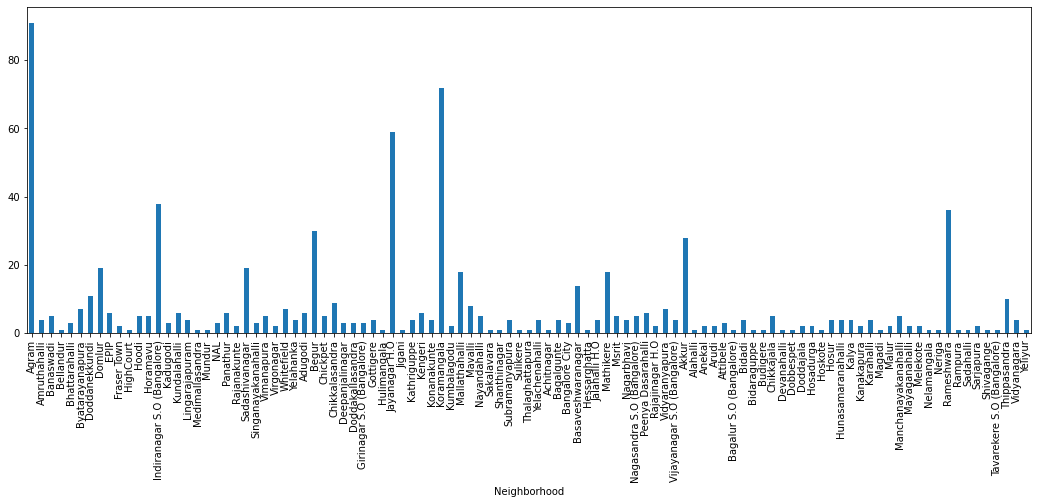

In [56]:
df_temp = bangalore_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df_temp.plot.bar(figsize=(18,6))

<AxesSubplot:xlabel='Neighborhood'>

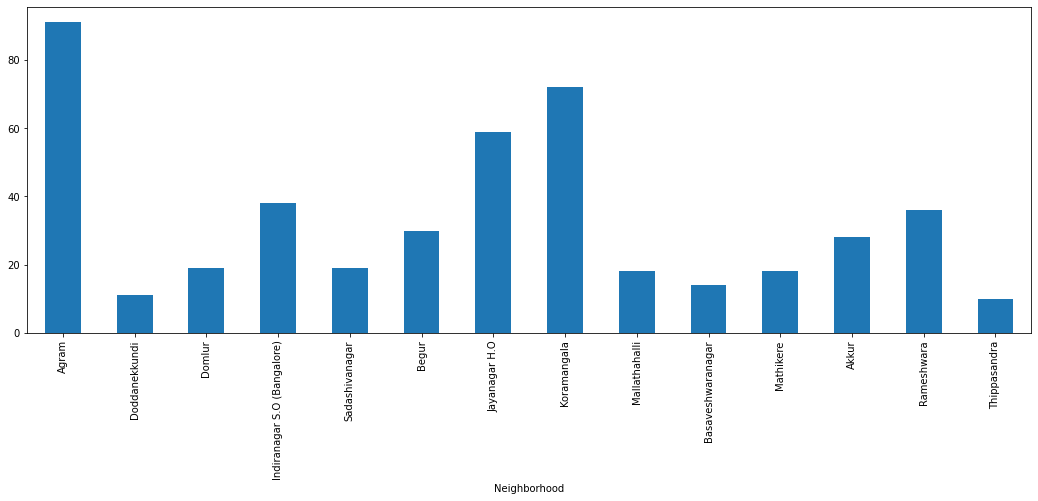

In [57]:
df10 = df_temp[df_temp >= 10]
df10.plot.bar(figsize=(18,6))

In [58]:
bangalore_venues_top = bangalore_venues[bangalore_venues['Neighborhood'].isin(df10.index.tolist())]
bangalore_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agram,45.813177,15.977048,Amélie,45.813842,15.979011,Dessert Shop
1,Agram,45.813177,15.977048,Trg bana Josipa Jelačića,45.813032,15.976868,Plaza
2,Agram,45.813177,15.977048,Vinodol,45.811666,15.975643,Mediterranean Restaurant
3,Agram,45.813177,15.977048,Gajbica,45.813531,15.979550,Bistro
4,Agram,45.813177,15.977048,Tržnica Dolac,45.814070,15.977261,Farmers Market


In [59]:
# one hot encoding
bangalore_onehot = pd.get_dummies(bangalore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangalore_onehot['Neighborhood'] = bangalore_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bangalore_onehot.columns[-1]] + list(bangalore_onehot.columns[:-1])
bangalore_onehot = bangalore_onehot[fixed_columns]

bangalore_onehot.head()

,Neighborhood,ATM,Accessories Store,American Restaurant,Andhra Restaurant,Arcade,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bakery,Bar,Baseball Field,Beach,Bengali Restaurant,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Diner,Discount Store,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Escape Room,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Gas Station,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Irish Pub,Italian Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Optical Shop,Other Nightlife,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,Rajasthani Restaurant,Resort,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Spanish Restaurant,Sports Bar,Sports Club,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Train Station,Travel & Transport,Tunnel,Turkish Coffeehouse,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Agram,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [60]:
bangalore_onehot.shape

(741, 167)

In [61]:
bangalore_grouped = bangalore_onehot.groupby('Neighborhood').mean().reset_index()
bangalore_grouped

,Neighborhood,ATM,Accessories Store,American Restaurant,Andhra Restaurant,Arcade,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,BBQ Joint,Badminton Court,Bakery,Bar,Baseball Field,Beach,Bengali Restaurant,Bike Shop,Bistro,Boarding House,Bookstore,Boutique,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Cafeteria,Café,Camera Store,Campground,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dhaba,Diner,Discount Store,Donut Shop,Dry Cleaner,Eastern European Restaurant,Electronics Store,Escape Room,Farm,Farmers Market,Fast Food Restaurant,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fried Chicken Joint,Gas Station,Gastropub,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Historic Site,History Museum,Hostel,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indian Sweet Shop,Irish Pub,Italian Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Maharashtrian Restaurant,Market,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Optical Shop,Other Nightlife,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,Rajasthani Restaurant,Resort,Restaurant,Rock Club,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,South Indian Restaurant,Spa,Spanish Restaurant,Sports Bar,Sports Club,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Toy / Game Store,Train Station,Travel & Transport,Tunnel,Turkish Coffeehouse,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Achitnagar,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Adugodi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.000000,0.00,0.000000,0.166667,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.00,0.000000,0.166667,0.0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

In [62]:
num_top_venues = 10

for hood in bangalore_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bangalore_grouped[bangalore_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Achitnagar----
             venue  freq
0       Food Truck   1.0
1              ATM   0.0
2     Optical Shop   0.0
3  Motorcycle Shop   0.0
4         Mountain   0.0
5    Movie Theater   0.0
6    Moving Target   0.0
7        Multiplex   0.0
8           Museum   0.0
9      Music Venue   0.0


----Adugodi----
                venue  freq
0         Bus Station  0.17
1                 Bar  0.17
2          Playground  0.17
3      Ice Cream Shop  0.17
4                Café  0.17
5  Athletics & Sports  0.17
6       Movie Theater  0.00
7       Moving Target  0.00
8           Multiplex  0.00
9              Museum  0.00


----Agram----
                      venue  freq
0                       Bar  0.09
1                     Plaza  0.08
2  Mediterranean Restaurant  0.04
3                Restaurant  0.04
4                    Bistro  0.04
5                      Café  0.04
6              Dessert Shop  0.04
7             Historic Site  0.04
8                   Theater  0.03
9          Pedestrian Pl

----Gottigere----
               venue  freq
0  Indian Restaurant  0.50
1   Department Store  0.25
2       Dessert Shop  0.25
3                ATM  0.00
4  Other Repair Shop  0.00
5      Movie Theater  0.00
6      Moving Target  0.00
7          Multiplex  0.00
8             Museum  0.00
9        Music Venue  0.00


----Hessarghatta----
             venue  freq
0           Bakery   1.0
1              ATM   0.0
2  Other Nightlife   0.0
3         Mountain   0.0
4    Movie Theater   0.0
5    Moving Target   0.0
6        Multiplex   0.0
7           Museum   0.0
8      Music Venue   0.0
9     Optical Shop   0.0


----HighCourt----
             venue  freq
0   Cosmetics Shop   1.0
1  Other Nightlife   0.0
2  Motorcycle Shop   0.0
3         Mountain   0.0
4    Movie Theater   0.0
5    Moving Target   0.0
6        Multiplex   0.0
7           Museum   0.0
8      Music Venue   0.0
9     Optical Shop   0.0


----Hoodi----
               venue  freq
0  Indian Restaurant   0.4
1        Yoga Studio  

             venue  freq
0           Bakery   1.0
1              ATM   0.0
2  Other Nightlife   0.0
3         Mountain   0.0
4    Movie Theater   0.0
5    Moving Target   0.0
6        Multiplex   0.0
7           Museum   0.0
8      Music Venue   0.0
9     Optical Shop   0.0


----NAL----
             venue  freq
0      Pizza Place  0.33
1         Bus Stop  0.33
2        Cafeteria  0.33
3  Other Nightlife  0.00
4    Movie Theater  0.00
5    Moving Target  0.00
6        Multiplex  0.00
7           Museum  0.00
8      Music Venue  0.00
9     Optical Shop  0.00


----Nagarbhavi----
               venue  freq
0               Café  0.50
1             Market  0.25
2  Indian Restaurant  0.25
3                ATM  0.00
4           Mountain  0.00
5      Movie Theater  0.00
6      Moving Target  0.00
7          Multiplex  0.00
8             Museum  0.00
9        Music Venue  0.00


----Nagasandra S.O (Bangalore)----
                  venue  freq
0                  Pool   0.2
1           Gas Stati

9             Museum  0.00


----Yelahanka----
               venue  freq
0                ATM  0.50
1      Train Station  0.25
2  Mobile Phone Shop  0.25
3    Motorcycle Shop  0.00
4           Mountain  0.00
5      Movie Theater  0.00
6      Moving Target  0.00
7          Multiplex  0.00
8             Museum  0.00
9        Music Venue  0.00


----Yeliyur----
             venue  freq
0    Train Station   1.0
1              ATM   0.0
2  Motorcycle Shop   0.0
3         Mountain   0.0
4    Movie Theater   0.0
5    Moving Target   0.0
6        Multiplex   0.0
7           Museum   0.0
8      Music Venue   0.0
9     Optical Shop   0.0




In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bangalore_grouped['Neighborhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Achitnagar,Food Truck,ATM,Optical Shop,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue
1,Adugodi,Bus Station,Bar,Playground,Ice Cream Shop,Café,Athletics & Sports,Movie Theater,Moving Target,Multiplex,Museum
2,Agram,Bar,Plaza,Mediterranean Restaurant,Restaurant,Bistro,Café,Dessert Shop,Historic Site,Theater,Pedestrian Plaza
3,Akkur,Supermarket,Pharmacy,Department Store,Clothing Store,Optical Shop,Chinese Restaurant,Sandwich Place,Bar,Toy / Game Store,Pet Store
4,Alahalli,Food & Drink Shop,ATM,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue,Optical Shop


In [65]:
bangalore_grouped_clustering = bangalore_grouped.drop('Neighborhood', 1)
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(bangalore_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 

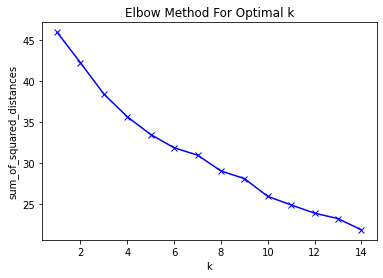

In [66]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

In [67]:
# set number of clusters
kclusters = 8

bangalore_grouped_clustering = bangalore_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 3, 1, 6, 1], dtype=int32)

In [68]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangalore_merged = bangalore_venues[bangalore_venues.columns[0:3]].drop_duplicates()

# merge toronto_grouped with bangalore_grouped to add latitude/longitude for each neighborhood
bangalore_merged = bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bangalore_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agram,45.813177,15.977048,1,Bar,Plaza,Mediterranean Restaurant,Restaurant,Bistro,Café,Dessert Shop,Historic Site,Theater,Pedestrian Plaza
91,Amruthahalli,13.066513,77.596624,1,Gym,Department Store,Print Shop,Shoe Store,ATM,Mountain,Movie Theater,Moving Target,Multiplex,Museum
95,Banaswadi,13.014162,77.651854,6,Indian Restaurant,Vegetarian / Vegan Restaurant,BBQ Joint,ATM,Other Nightlife,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex
100,Bellandur,58.235358,26.683117,1,Restaurant,ATM,Other Nightlife,Motorcycle Shop,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Venue
101,Bhattarahalli,13.025800,77.714279,1,Ice Cream Shop,Hotel,Café,ATM,Other Nightlife,Mountain,Movie Theater,Moving Target,Multiplex,Museum


<h1> 5.	Results and Discussion </h1>

After clustering and segmenting following clusters have been created and analyzed graphically to identify the ideal locations to open:
a)	Hotel 
b)	Coffee Shop
Review below the graphs of the various clustering providing the number of venues by venue name.


In [69]:
cluster1=bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 0, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]]

ven_list_1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

In [70]:
cluster2=bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 1, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]]

ven_list_2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

In [71]:
cluster3=bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 2, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]]

ven_list_3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

In [72]:
cluster4=bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 3, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]]

ven_list_4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

In [73]:
cluster5=bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 4, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]]

ven_list_5 = (cluster5['1st Most Common Venue'].append(
    cluster5['2nd Most Common Venue']).append(
    cluster5['3rd Most Common Venue']).append(
    cluster5['4th Most Common Venue']).append(
    cluster5['5th Most Common Venue']).append(
    cluster5['6th Most Common Venue']).append(
    cluster5['7th Most Common Venue']).append(
    cluster5['8th Most Common Venue']).append(
    cluster5['9th Most Common Venue']).append(
    cluster5['10th Most Common Venue']))

In [74]:
cluster6=bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 5, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]]

ven_list_6 = (cluster6['1st Most Common Venue'].append(
    cluster6['2nd Most Common Venue']).append(
    cluster6['3rd Most Common Venue']).append(
    cluster6['4th Most Common Venue']).append(
    cluster6['5th Most Common Venue']).append(
    cluster6['6th Most Common Venue']).append(
    cluster6['7th Most Common Venue']).append(
    cluster6['8th Most Common Venue']).append(
    cluster6['9th Most Common Venue']).append(
    cluster6['10th Most Common Venue']))

In [75]:
cluster7=bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 6, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]]

ven_list_7 = (cluster7['1st Most Common Venue'].append(
    cluster7['2nd Most Common Venue']).append(
    cluster7['3rd Most Common Venue']).append(
    cluster7['4th Most Common Venue']).append(
    cluster7['5th Most Common Venue']).append(
    cluster7['6th Most Common Venue']).append(
    cluster7['7th Most Common Venue']).append(
    cluster7['8th Most Common Venue']).append(
    cluster7['9th Most Common Venue']).append(
    cluster7['10th Most Common Venue']))

In [76]:
cluster8=bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 7, bangalore_merged.columns[[0] + list(range(4, bangalore_merged.shape[1]))]]

ven_list_8 = (cluster8['1st Most Common Venue'].append(
    cluster8['2nd Most Common Venue']).append(
    cluster8['3rd Most Common Venue']).append(
    cluster8['4th Most Common Venue']).append(
    cluster8['5th Most Common Venue']).append(
    cluster8['6th Most Common Venue']).append(
    cluster8['7th Most Common Venue']).append(
    cluster8['8th Most Common Venue']).append(
    cluster8['9th Most Common Venue']).append(
    cluster8['10th Most Common Venue']))

<AxesSubplot:>

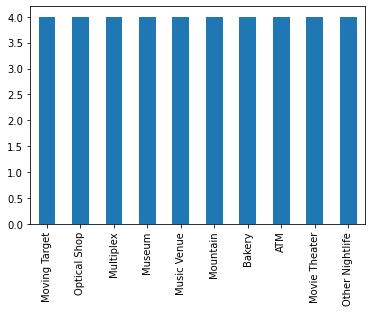

In [77]:
ven_list_1.value_counts().head(15).plot.bar()

<AxesSubplot:>

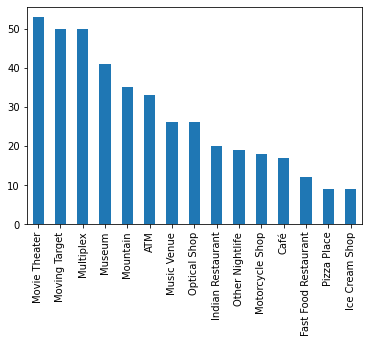

In [78]:
ven_list_2.value_counts().head(15).plot.bar()

<AxesSubplot:>

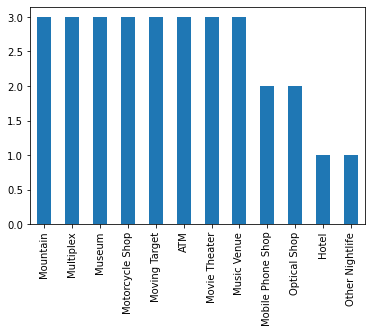

In [79]:
ven_list_3.value_counts().head(15).plot.bar()

<AxesSubplot:>

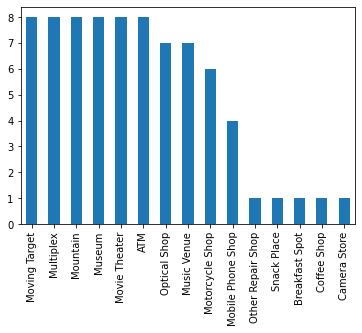

In [80]:
ven_list_4.value_counts().head(15).plot.bar()

<AxesSubplot:>

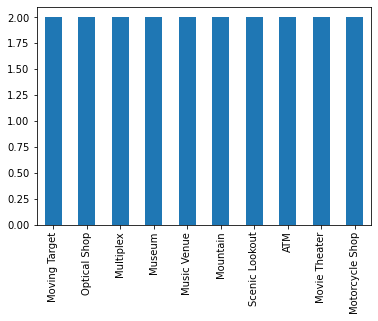

In [81]:
ven_list_5.value_counts().head(15).plot.bar()

<AxesSubplot:>

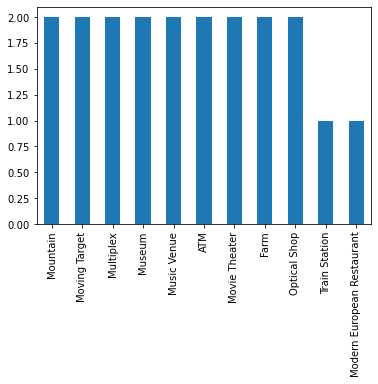

In [82]:
ven_list_6.value_counts().head(15).plot.bar()

<AxesSubplot:>

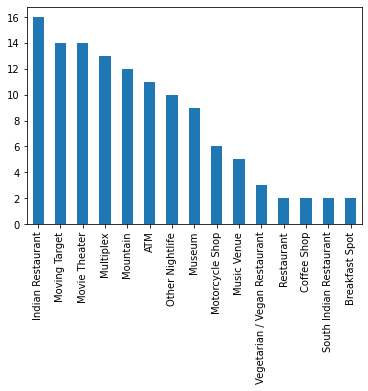

In [83]:
ven_list_7.value_counts().head(15).plot.bar()

<AxesSubplot:>

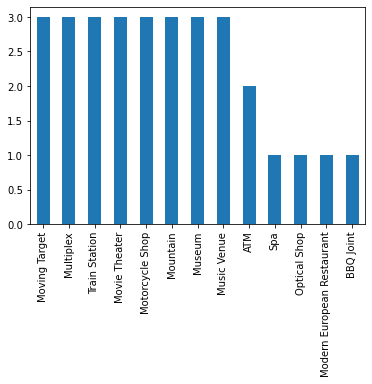

In [84]:
ven_list_8.value_counts().head(15).plot.bar()

In [85]:
bangalore_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangalore_merged['Neighborhood Latitude'], bangalore_merged['Neighborhood Longitude'], bangalore_merged['Neighborhood'], bangalore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(bangalore_clusters_map)
       
bangalore_clusters_map